![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [3]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [4]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produto = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [5]:
#create engine = banco de dados
engine = create_engine('sqlite:///:memory:')

In [6]:
produto.to_sql('produtos', engine, index = False)

205

In [7]:
itens_pedidos.to_sql('itens_pedidos', engine, index = False)
pedidos.to_sql('pedidos', engine, index = False)
vendedores.to_sql('vendedores', engine, index = False)

5

In [8]:
inspetor = inspect(engine)
print(inspetor.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [9]:
query = 'SELECT CONDICAO FROM PRODUTOS'

In [10]:
with engine.connect() as conexao:
  consulta =  conexao.execute(text(query))
  dados = consulta.fetchall()

In [11]:
pd.DataFrame(dados, columns = consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [12]:
def sql_df(query):
  with engine.connect() as conexao:
    consulta =  conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns = consulta.keys())


Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [13]:
query = '''SELECT CONDICAO, COUNT(*) as Quantidade FROM PRODUTOS GROUP BY CONDICAO;'''
#aspas triplas tem quebra de linha
df_produtos = sql_df(query)

print(df_produtos)
#maioria dos produtos são usados

            Condicao  Quantidade
0  Novo com etiqueta          22
1  Novo sem etiqueta           7
2              Usado         176


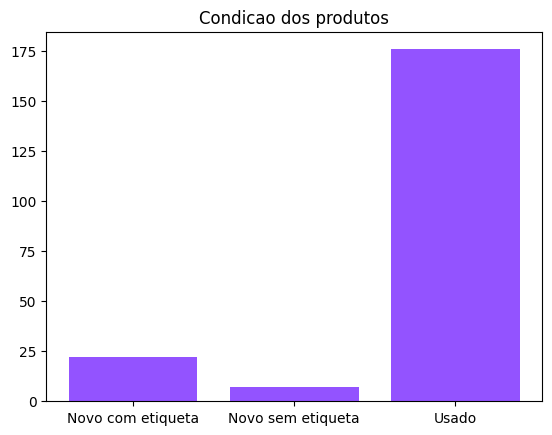

In [14]:
#gráfico colunas/barras eixo x                        eixo y
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color = '#9353FF')
plt.title('Condicao dos produtos')
plt.show()

In [15]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [16]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [17]:
query = '''SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS quantidade
FROM ITENS_PEDIDOS, PRODUTOS WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID GROUP BY PRODUTOS.PRODUTO
ORDER BY quantidade ASC'''

#LIMIT 5 OFFSET 5
# Retorna 4 registros a partir do 6°


df_prod_quantid = sql_df(query)
df_prod_quantid

,produto,quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


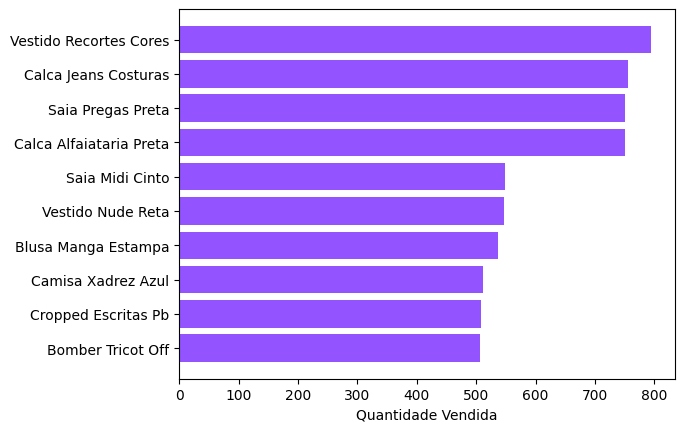

In [18]:
plt.barh(df_prod_quantid['produto'][-10:], df_prod_quantid['quantidade'][-10:], color = '#9353FF')
plt.xlabel('Quantidade Vendida')
plt.show()

In [19]:
df_itens_pedidos = sql_df('SELECT VALOR_TOTAL FROM ITENS_PEDIDOS')
receita = df_itens_pedidos['valor_total'].sum()
receita

45803930

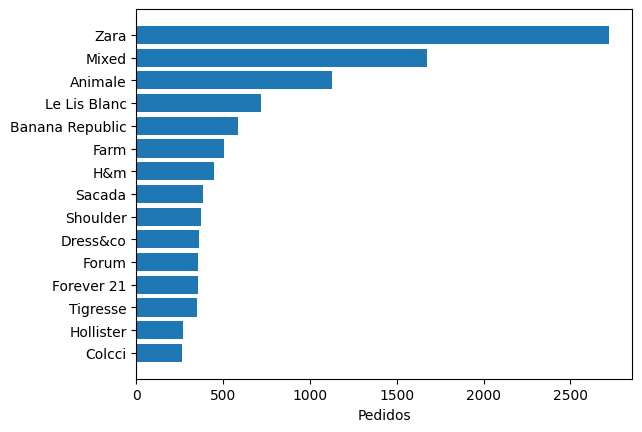

In [20]:
query = '''SELECT PRODUTOS.MARCA, COUNT(*) AS Pedidos FROM PRODUTOS, ITENS_PEDIDOS WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID GROUP BY PRODUTOS.MARCA
ORDER BY COUNT(*) ASC '''

df_marcas = sql_df(query)

plt.barh(df_marcas['marca'][-15:], df_marcas['Pedidos'][-15:])
plt.xlabel('Pedidos')
plt.show()

In [29]:
query = '''SELECT PRODUTOS.PRODUTO , COUNT(PEDIDOS.PEDIDO_ID) AS TOTAL_PEDIDOS FROM PEDIDOS, PRODUTOS
WHERE strftime('%Y', data_compra) = '2019' AND PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO ORDER BY TOTAL_PEDIDOS DESC
LIMIT 10;
'''


sql_df(query)

,produto,TOTAL_PEDIDOS
0,Vestido Recortes Cores,85
1,Calca Jeans Costuras,81
2,Saia Pregas Preta,73
3,Calca Alfaiataria Preta,66
4,Camisa Xadrez Azul,60
5,Bomber Tricot Off,56
6,Shorts Bordado Branco,55
7,Blusa Manga Estampa,54
8,Saia Midi Cinto,53
9,Saia Evase Cinza,53


In [30]:
query = '''SELECT strftime('%m', data_compra) AS mes, SUM(total) AS receita FROM pedidos WHERE strftime('%Y', data_compra) = '2021' GROUP BY mes;'''

sql_df(query)

,mes,receita
0,01,2097109
1,02,1140729
2,03,51525


# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [31]:
sql_df('SELECT * FROM PEDIDOS').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [32]:
sql_df('SELECT * FROM PEDIDOS').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

In [33]:
#data = strftime
query = ''' SELECT * FROM PEDIDOS WHERE strftime('%Y', data_compra) = '2020';
'''

sql_df(query)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,112772,84743,3,2020-01-01,720
1,112909,56350,3,2020-01-01,1225
2,113068,70673,2,2020-01-01,1050
3,113453,16634,3,2020-01-01,2880
4,114487,43054,1,2020-01-01,640
...,...,...,...,...,...
14540,26762,9981,4,2020-12-31,8000
14541,27016,20029,3,2020-12-31,1764
14542,27666,12895,5,2020-12-31,10400
14543,28206,29893,4,2020-12-31,2100


In [34]:
query = '''SELECT VENDEDOR_ID, COUNT(*) FROM PEDIDOS WHERE strftime('%Y', data_compra) = '2020' GROUP BY VENDEDOR_ID;'''

sql_df(query)

,vendedor_id,COUNT(*)
0,1,3427
1,2,3338
2,3,2782
3,4,2510
4,5,2488


In [35]:
query = '''SELECT strftime('%m', data_compra) AS mes, COUNT(*) AS quantidade FROM pedidos WHERE strftime('%Y', data_compra) = '2019' GROUP BY mes'''
vendas_19 = sql_df(query)
vendas_19

,mes,quantidade
0,01,141
1,02,333
2,03,501
3,04,456
4,05,650
5,06,567
6,07,738
7,08,745
8,09,802
9,10,866


In [37]:
query = '''SELECT strftime('%m', data_compra) AS mes, COUNT(*) AS quantidade FROM pedidos WHERE strftime('%Y', data_compra) = '2020' GROUP BY mes'''
vendas_20 = sql_df(query)
vendas_20

,mes,quantidade
0,01,1271
1,02,1197
2,03,1280
3,04,1276
4,05,1206
5,06,896
6,07,984
7,08,1163
8,09,1221
9,10,1139


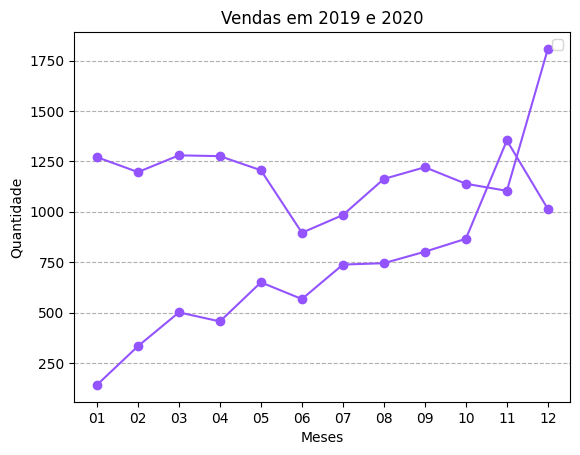

In [38]:
import matplotlib.pyplot as plt

plt.plot(vendas_19.mes.to_numpy(), vendas_19.quantidade.to_numpy(), marker = 'o', linestyle='-', color = '#9353FF')
plt.plot(vendas_20.mes.to_numpy(), vendas_20.quantidade.to_numpy(), marker = 'o', linestyle='-', color = '#9353FF')

plt.title('Vendas em 2019 e 2020')
plt.xlabel('Meses')
plt.ylabel('Quantidade')

plt.legend()

plt.grid(axis = 'y', linestyle = '--')

plt.show()

In [39]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas' FROM PEDIDOS, VENDEDORES WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR ORDER BY AVG(PEDIDOS.TOTAL) DESC;'''

#AVG MÉDIA DOS VALORES, CNTL SHIFT L SELECIONA AS PARTES

sql_df(query)

,nome_vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

In [41]:
query = '''SELECT ESTADO, COUNT(*) AS Pedidos
FROM ITENS_PEDIDOS GROUP BY ESTADO ORDER BY Pedidos DESC'''


sql_df(query)

,Estado,Pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.

In [48]:
query = ''' SELECT VENDEDORES.NOME_VENDEDOR, COUNT(*) AS quantidade_vendas
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR ORDER BY quantidade_vendas DESC
'''


sql_df(query)

,nome_vendedor,quantidade_vendas
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157
